In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import os
import scprinter as scp
from tqdm.auto import tqdm, trange
import math
from joblib import Parallel, delayed
from scipy import stats
import seaborn as sns
from scipy.stats import binomtest
import os
import ast
import pickle

## Load Metadata

In [4]:
Regions = pd.read_csv('20250716_FT13/final_figs/Regions.csv')

In [8]:
Regions

,Chromosome,amplicon_start,amplicon_end,label,motif_start,motif_end,forward_bool,rev_bool,composite_orientation,composite_match_loc
0,chr4,104933817,104934732,AP1 only,104934247,104934259,0,0,NaN,NaN
1,chr6,30307429,30308352,AP1 only,30307892,30307904,0,0,NaN,NaN
2,chr12,85050797,85051696,AP1 only,85051308,85051320,0,0,NaN,NaN
3,chr4,129793668,129794587,AP1 only,129794186,129794198,0,0,NaN,NaN
4,chr4,126168183,126169106,AP1 only,126168682,126168694,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
58,chr6,8618748,8619659,AP1 + Fox,8619262,8619274,1,0,forward,"(-15, 3)"
59,chr3,51283498,51284412,AP1 + Fox,51283941,51283953,0,1,reverse,"(-4, 14)"
60,chr11,101492718,101493624,AP1 + Fox,101493205,101493214,1,0,forward,"(-14, 4)"
61,chr10,97793491,97794391,AP1 + Fox,97793976,97793988,1,0,forward,"(-15, 3)"


## Calculate Footprint Scores from Fragment Files (demonstrating this step, but footprint scores will be loaded in from a pkl file)

In [211]:
# these were sample barcodes included in fragment files
barcodes = ['CH_FOSFOXA1_S11_001',
            'CH_Control_1_S17_001',
            'CH_JUNFOSFOXA1_S12_001',
            'CH_FOS_S2_001',
            'CH_JUNFOXA1_S10_001',
            'CH_FOSFOXP1_S8_001',
            'CH_Control_2_S18_001',
            'CH_FOXA1_S4_001',
            'CH_JUNFOS_S6_001',
            'CH_JUNFOXP1_S7_001',
            'CH_JUN_S1_001',
            'CH_JUNFOSFOXP1_S9_001',
            'CH_FOXP1_S3_001']

In [ ]:
bcodes=np.array(barcodes).reshape(-1,1)

In [ ]:
## Use scprinter to calculate insertions and collect them from printer object

start = time.time()
printer = scp.pp.import_fragments(
                    path_to_frags='20250716_FT13/fragments/downsamp_frags.tsv.gz', #all condition downsampled to same number of frags
                    barcodes=barcodes,
                    savename='20250716_FT13/printer.h5ad',
                    genome=scp.genome.mm10,
                    plus_shift=4,
                    minus_shift=-5,
                    min_num_fragments=0, min_tsse=0,
                    sorted_by_barcode=True)
print ("takes", time.time()-start)

insertion_list=[]

for _,row in Regions.iterrows():
    reg=row["Chromosome"]+':'+str(row['amplicon_start'])+'-'+str(row['amplicon_end'])
    insertions = scp.io.get_group_atac(printer, bcodes, reg)
    insertion_list.append(insertions)

In [ ]:
def compute_log_p(i, j, insertions, condition, control):
    
    k_flank = insertions[condition, j-2*i:j-i].sum() + insertions[condition, j+i+1:j+2*i+1].sum()
    k_center = insertions[condition, j-i:j+i+1].sum()
    k_total = k_flank + k_center
    
    #Find modifiable bases in center and glank
    p_flank = insertions[control, j-2*i:j-i].sum() + insertions[control, j+i+1:j+2*i+1].sum()

    #take center with radius i
    p_center = insertions[control, j-i:j+i+1].sum()
    p_total = p_flank + p_center
    
    log_p = 0
    
    if (k_total >= 1) & (p_total >= 1):
        
        prob = p_center/p_total

        result = binomtest(int(k_center), int(k_total), p=prob, alternative='less')
        p = result.pvalue
        
        log_p = np.log10(p)
    
    return (int(i), j, log_p)

def parallel_compute_log_ps(insertions, scales, condition_index, control_index):
    
    log_ps = np.empty((len(scales), insertions.shape[1]))
    
    max_r=scales.max()
    min_r=scales.min()
    results = Parallel(n_jobs=16)(delayed(compute_log_p)(i, j, insertions, condition_index, control_index) for i in scales for j in trange(max_r, insertions.shape[1]-max_r))
    
    for idx, j, log_p in results:
        
        # print(j)
        log_ps[int(idx-min_r), j] = log_p
    
    return log_ps

In [ ]:
## Calculate footprint scores from insertions

all_log_ps=[]
radius_range=np.arange(2,101,1)
control = 6
# specify control to footprint against to account for tn5 bias; 
# all conditions were footprinted against Control_2, meaning that Control_2 should be ignored in subsequent analyses

for reg in insertion_list:

    reg_log_ps=[]
    
    for cond in tqdm(range(0,13):
        
        log_ps = parallel_compute_log_ps(reg, radius_range, cond, control)
        reg_log_ps.append(log_ps)
     
    all_log_ps.append(reg_log_ps)

## Load footprint scores

In [9]:
footprint_files = os.listdir('20250716_FT13/final_figs/footprint_scores')

In [10]:
prefootprints = []
labels=[]
for file_name in footprint_files:
    
    with open("20250716_FT13/final_figs/footprint_scores/"+file_name, 'rb') as file:
        
        prints = pickle.load(file)
        label=file_name.split('_foot')[0]
        
        prefootprints.append(prints)
        labels.append(label)

In [12]:
# Restructure to Region x Sample x Scale x RegionLength
footprints = [
    [arr[sample_idx] for arr in prefootprints]
    for sample_idx in range(63)
]

## First and last 100 basepairs of each region should be ignored because of how footprint scores are calculated (center vs flank comparisons)

In [13]:
ap1only_bools = (Regions['label']=='AP1 only').to_numpy()
ap1fox_bools = (Regions['label']=='AP1 + Fox').to_numpy()

## Extract footprint scores for plotting

In [14]:
scale=12 #this index corresponds to a radius of 14 
values=[] #footprint scores +/- 100 bp around motif center at radius 14
motif_scores=[] #mean footprint scores in motif at radius 14
multis=[] #footprint scores +/- 100 bp around motif center at all scales


for i, row in tqdm(Regions.iterrows()):
    
    reg_signal=np.array(footprints[i])
    
    s=row['motif_start']-row['amplicon_start']
    e=row['motif_end']-row['amplicon_start']

    m=(s+e)//2
    
    vals=reg_signal[:,scale, m-100:m+101]
    
    if row['composite_orientation']=='reverse':
        values.append(np.flip(vals, axis=-1))
    else:
        values.append(vals)

    motif_score=reg_signal[:,scale, s:e].mean(axis=-1)
    motif_scores.append(motif_score)

    multi=reg_signal[:,:, m-100:m+101]
    multis.append(multi)

0it [00:00, ?it/s]

## Stacked Plots

In [15]:
ap1only_stacked_vals=np.array(values)[ap1only_bools].transpose(1,0,2)
ap1fox_stacked_vals=np.array(values)[ap1fox_bools].transpose(1,0,2)

In [16]:
#plot JUNFOS first to order the clustering in the clustermaps
orderplot=list(np.where(np.array(labels)=='JUNFOS')[0])+list(np.where(np.array(labels)!='JUNFOS')[0])

/tmp/ipykernel_557125/2515061483.py:28: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2515061483.py:28: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2515061483.py:28: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2515061483.py:28: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(

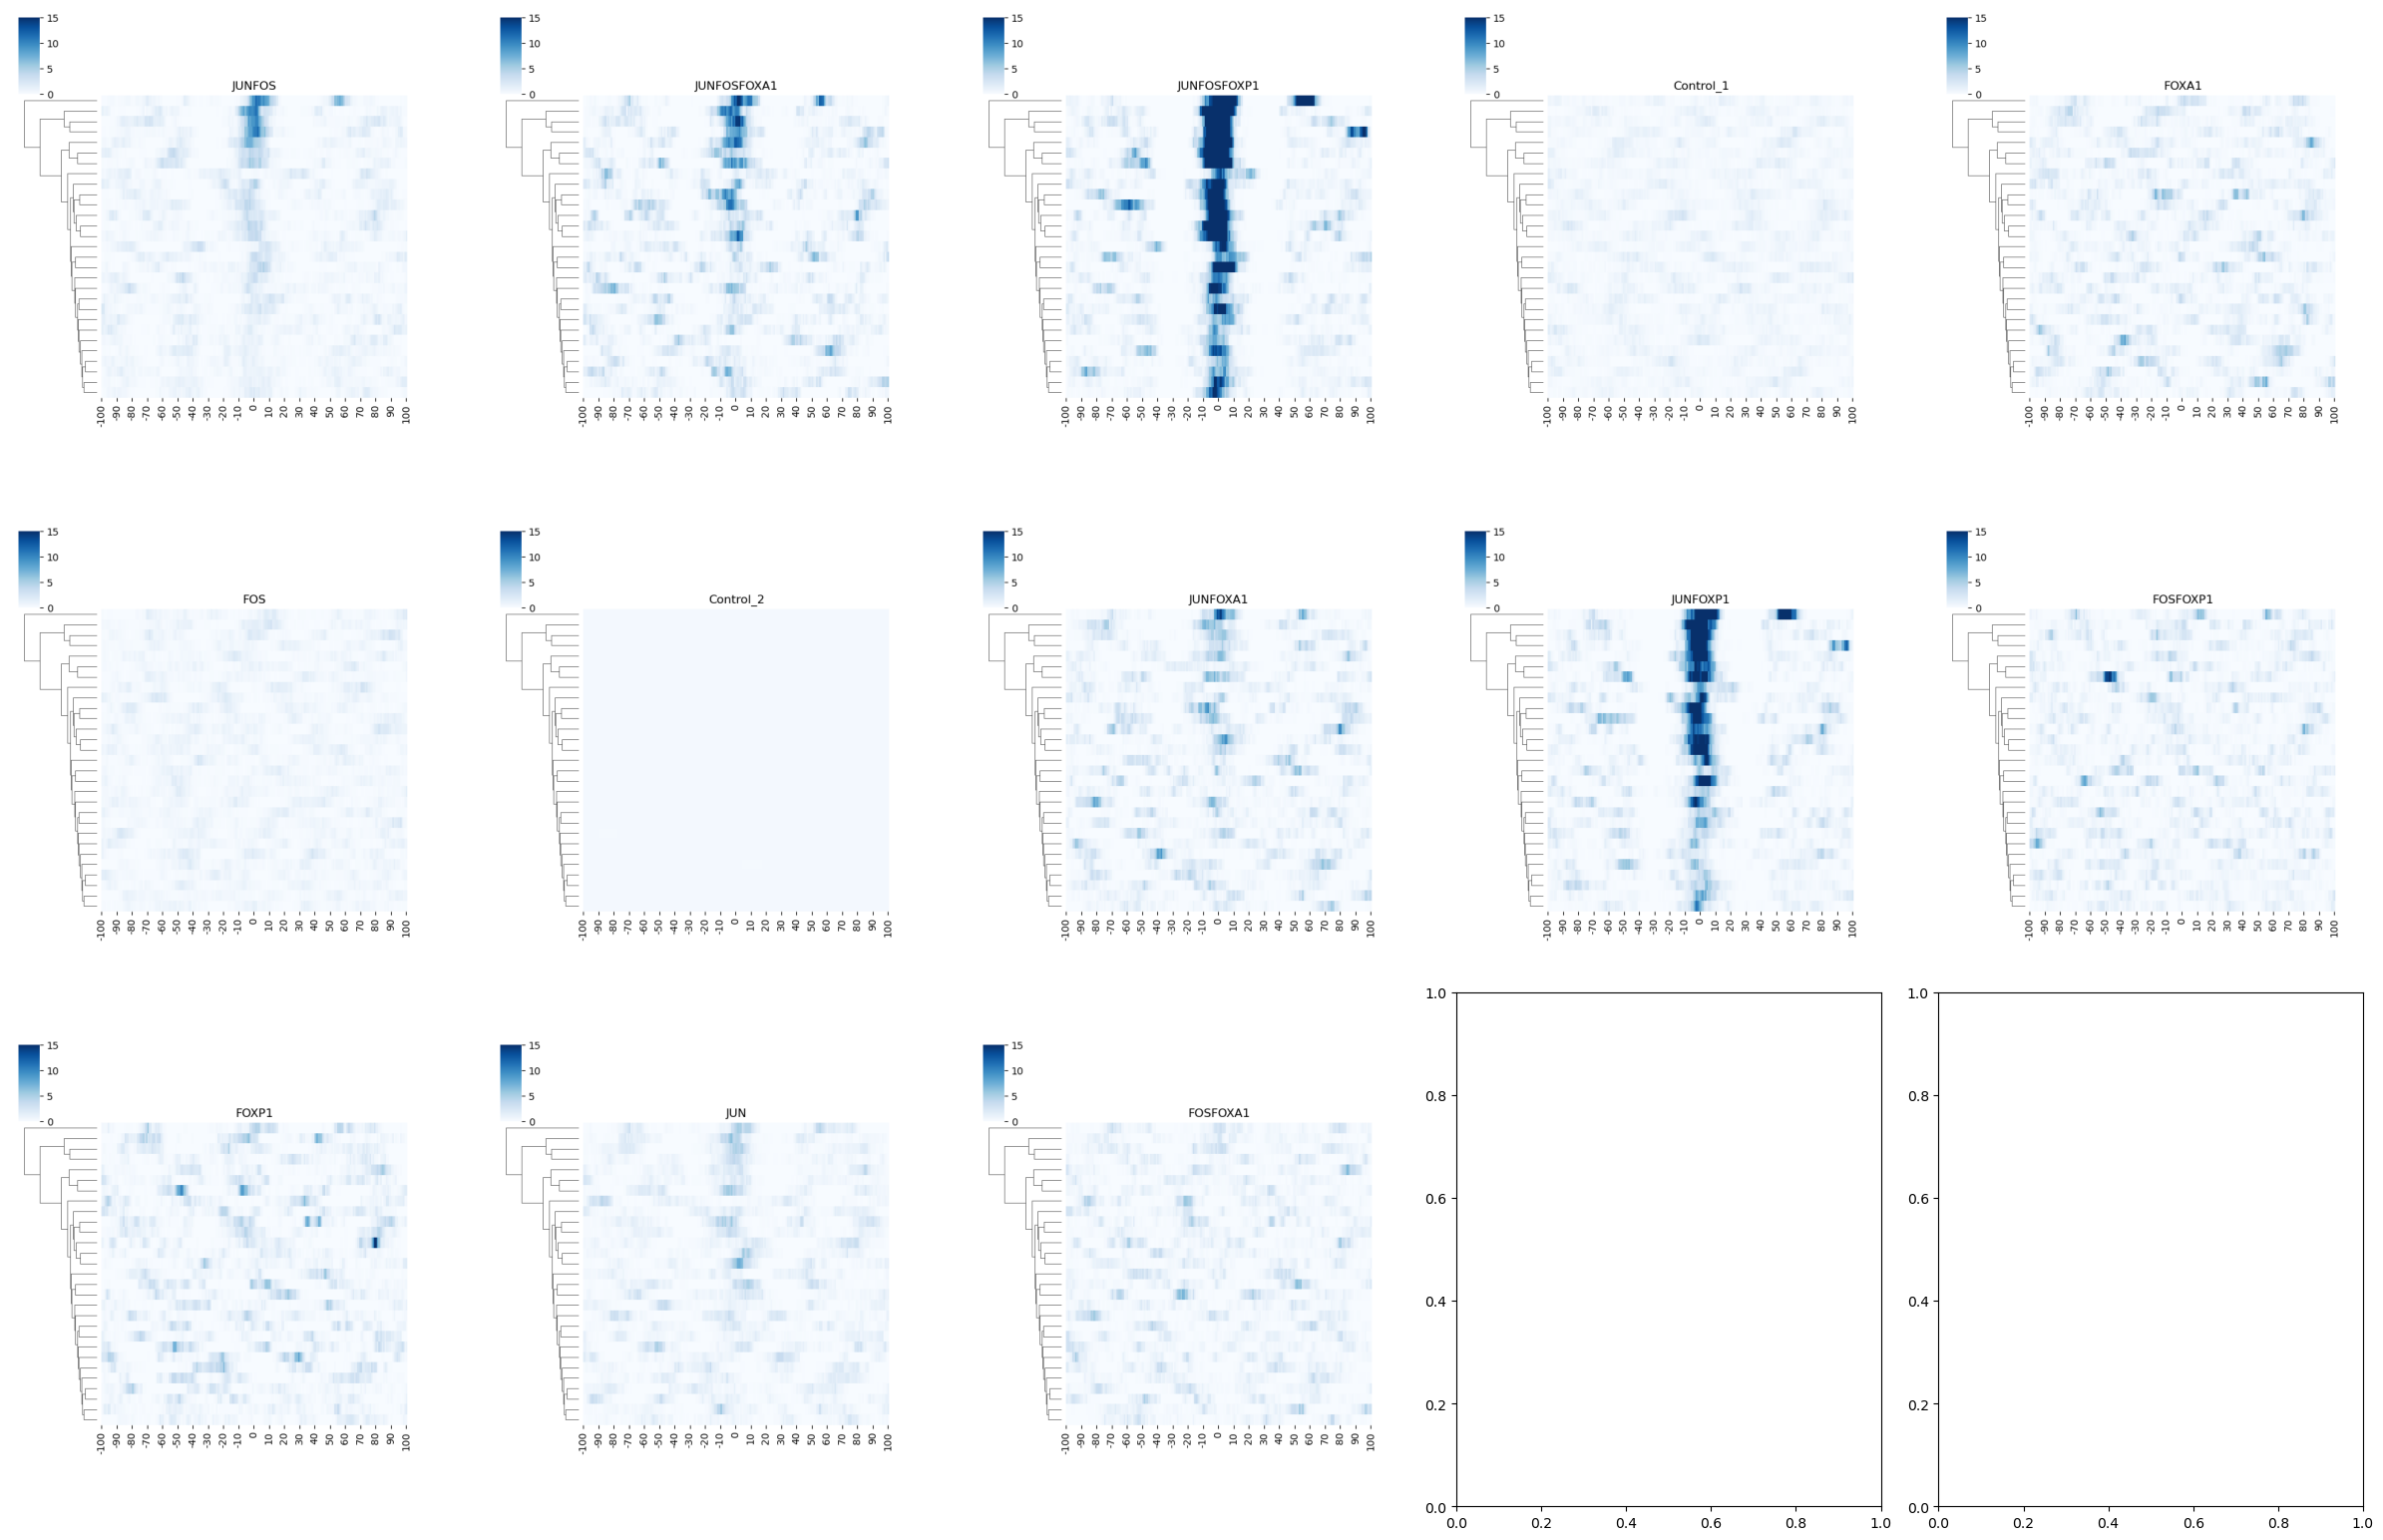

In [17]:
link_set = False
fig, axes = plt.subplots(3, 5, figsize=(24, 16))  # 4 columns x 2 rows
axes = axes.flatten()
vm=15

for idx, (vals, label) in enumerate(zip(ap1only_stacked_vals[orderplot], np.array(labels)[orderplot])):
    # Create a clustermap for this matrix
    if link_set:
        clustmap = sns.clustermap(vals, cmap='Blues', vmin=0, vmax=vm,
                                  row_linkage=links, col_cluster=False, figsize=(6,6))
    else:
        clustmap = sns.clustermap(vals, cmap='Blues', vmin=0, vmax=vm,
                                  col_cluster=False, figsize=(6,6))
        link_set = True
        links = clustmap.dendrogram_row.linkage
    
    # Extract the heatmap and plot it in the larger figure
    heatmap_ax = clustmap.ax_heatmap
    for spine in heatmap_ax.spines.values():
        spine.set_visible(False)
    
    heatmap_ax.set_xticks(np.arange(0,210,10), np.arange(-100,110,10))
    heatmap_ax.set_title(label)
    heatmap_ax.set_yticks([])
    # clustmap.savefig(f"20250716_FT13/sn_figs/{label}"+'_stackedAP1only_vmax'+str(vm)+"_subplot.pdf", bbox_inches='tight')

    clustmap.fig.canvas.draw()
    img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(clustmap.fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(clustmap.fig)

    # Plot image onto subplot
    axes[idx].imshow(img_array)
    axes[idx].set_xticks(np.arange(0,210,10), np.arange(-100,110,10))
    axes[idx].axis('off')
    # axes[idx].set_title(label)


plt.tight_layout()
plt.show()

/tmp/ipykernel_557125/2197956674.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2197956674.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2197956674.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_557125/2197956674.py:30: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(

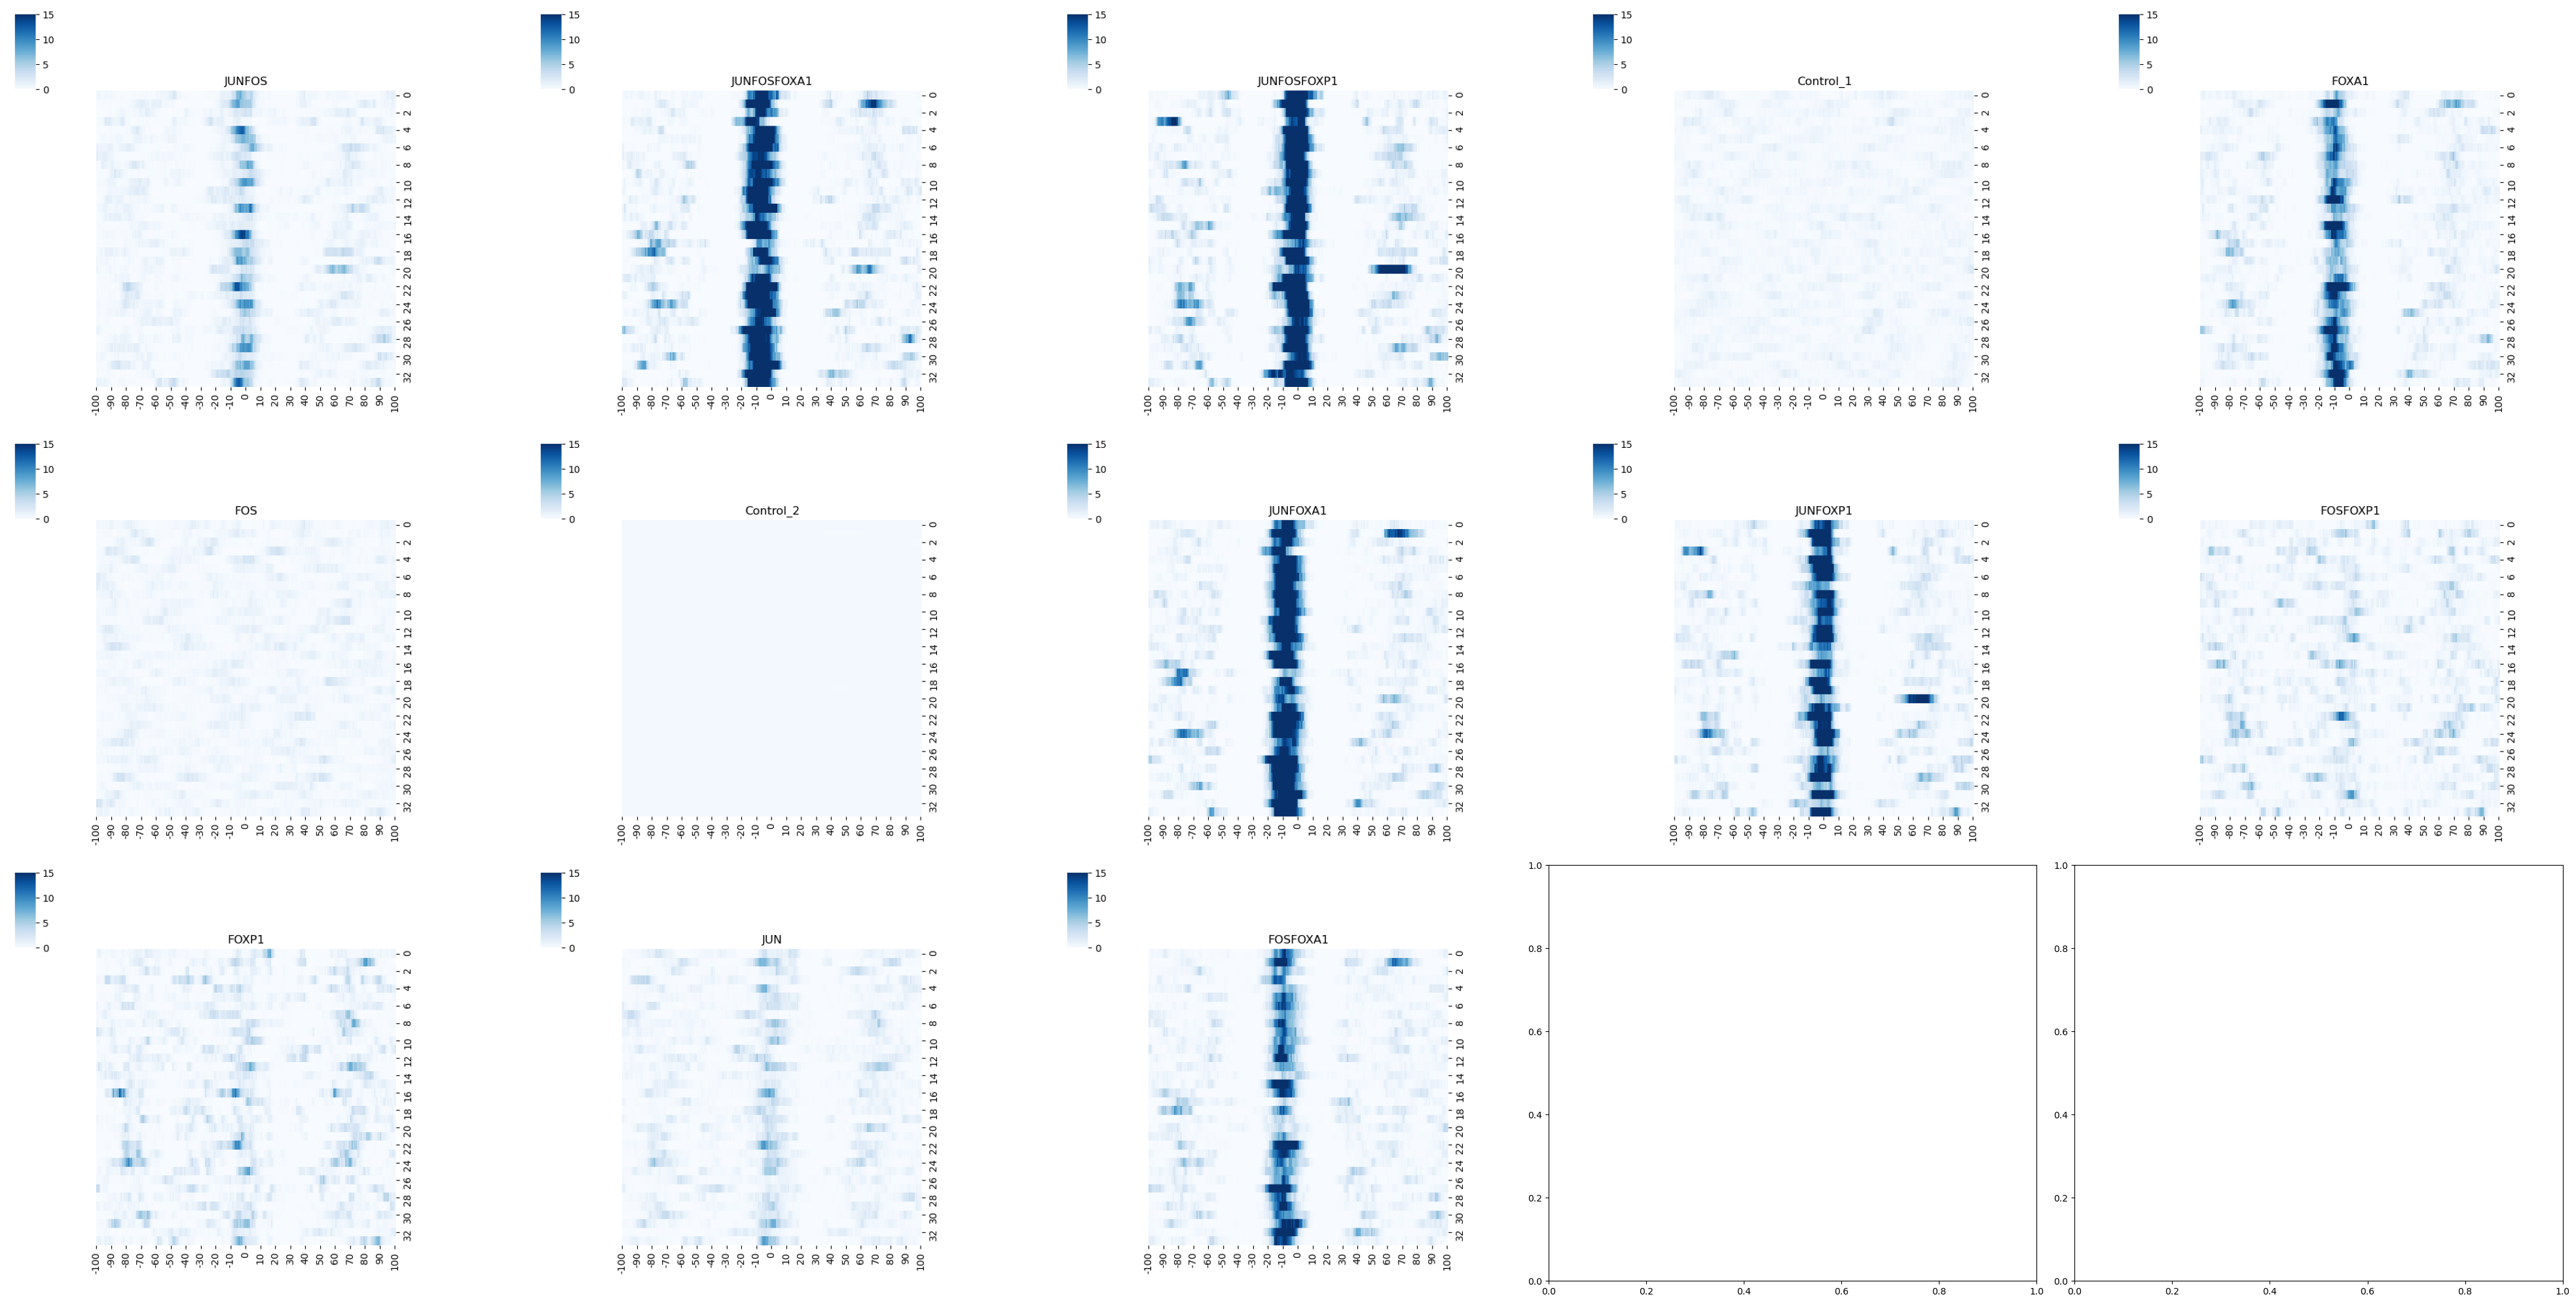

In [18]:
link_set = False
fig, axes = plt.subplots(3, 5, figsize=(40, 20))  # 4 columns x 2 rows
axes = axes.flatten()
vm=15

for idx, (vals, label) in enumerate(zip(ap1fox_stacked_vals[orderplot], np.array(labels)[orderplot])):
    # Create a clustermap for this matrix
    if link_set:
        clustmap = sns.clustermap(vals, cmap='Blues', vmin=0, vmax=vm,
                                  row_cluster=False, col_cluster=False, figsize=(6,6)) #row_linkage=links, )
    else:
        clustmap = sns.clustermap(vals, cmap='Blues', vmin=0, vmax=vm,
                                  col_cluster=False, row_cluster=False, figsize=(6,6))
        # link_set = True
        # links = clustmap.dendrogram_row.linkage
    
    # Extract the heatmap and plot it in the larger figure
    heatmap_ax = clustmap.ax_heatmap
    for spine in heatmap_ax.spines.values():
        spine.set_visible(False)
    
    heatmap_ax.set_xticks(np.arange(0,210,10), np.arange(-100,110,10))
    heatmap_ax.set_title(label)
    # labs=heatmap_ax.get_yticks()
    # heatmap_ax.set_yticks(np.arange(0,len(vals),1), labs)
    # clustmap.savefig(f"20250716_FT13/sn_figs/{label}"+'_stackedAP1fox_vmax'+str(vm)+"_subplot.pdf", bbox_inches='tight')

    # Draw heatmap to a temporary canvas to extract image
    clustmap.fig.canvas.draw()
    img_array = np.frombuffer(clustmap.fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(clustmap.fig.canvas.get_width_height()[::-1] + (3,))
    
    # Clear the clustermap to free memory
    plt.close(clustmap.fig)

    # Plot image onto subplot
    axes[idx].imshow(img_array)
    axes[idx].set_xticks(np.arange(0,210,10), np.arange(-100,110,10))
    axes[idx].axis('off')
    # axes[idx].set_title(label)


plt.tight_layout()
plt.show()

## Line Plots

In [19]:
score_means_ap1only=np.array(values)[ap1only_bools].mean(axis=0)
score_means_ap1fox=np.array(values)[ap1fox_bools].mean(axis=0)

In [20]:
foxa1_keep = [i for i, elem in enumerate(labels) if elem in ['FOXA1','JUNFOS','JUNFOSFOXA1', 'Control_1']]
foxp1_keep = [i for i, elem in enumerate(labels) if elem in ['FOXP1','JUNFOS','JUNFOSFOXP1', 'Control_1']]

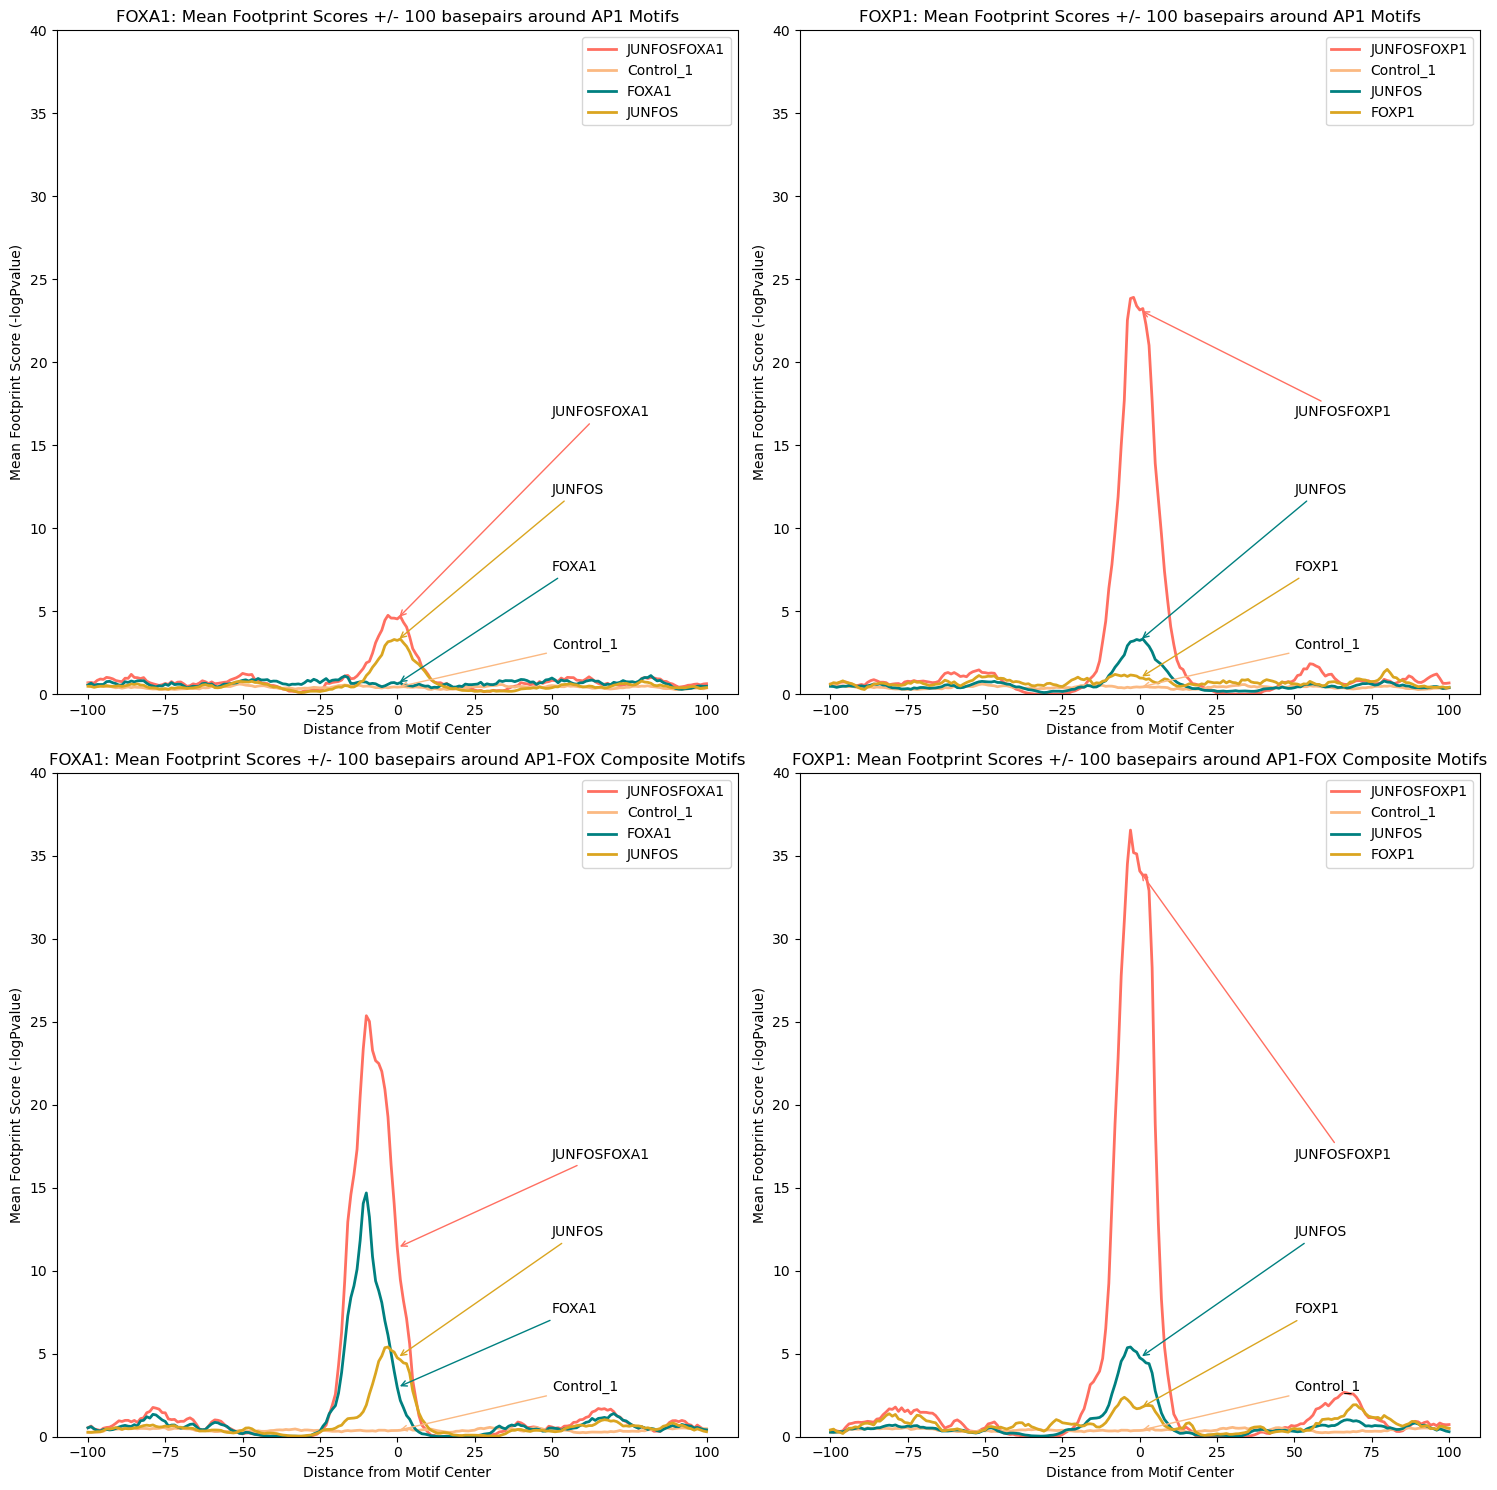

In [21]:
colors = [
    "#FF6F61",  # Coral Red
    "#FBB982",  # Apricot
    "#008080",  # Deep Teal
    "#DAA520",  # Goldenrod
    
]

x = np.arange(-100,101,1)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for conds, ax, tf_name in zip([foxa1_keep, foxp1_keep], axes.ravel()[:2], ['FOXA1','FOXP1']):
    
    i=0

    scores = score_means_ap1only[conds]
    scores_at_100 = scores[:, 100]  
    order = np.argsort(scores_at_100)[::-1]       # Descending order (highest first)

    # Create spaced vertical offsets (highest gets largest offset)
    y_arrow_locs = np.linspace(7, 0, len(order))  # e.g., [7,6,5,...,0]
    # Now reorder based on original position (so it matches the loop order)
    reordered_y_offsets = np.zeros_like(y_arrow_locs)
    reordered_y_offsets[order] = y_arrow_locs*2 +3
    
    
    for tf, label, color in zip(scores, np.array(labels)[conds], colors):
    
        ax.plot(x, tf, color=color, label=label, linewidth=2)
    
        # Choose a point near the end of the line
        x_arrow = x[100]
        y_arrow = tf[100]
    
        # Annotate with arrow
        ax.annotate(
            label,
            xy=(x_arrow, y_arrow),
            # xytext=(x_arrow + 20, y_arrow+y_arrow_add[i]),
            xytext=(x_arrow + 50, reordered_y_offsets[i]),
            # xytext=(x_arrow + 40, y_arrow),
            arrowprops=dict(arrowstyle="->", color=color),
            fontsize=10,
            color='black',
            va='center'
        )
        
        i+=1
    
        ax.legend()
        ax.set_ylabel('Mean Footprint Score (-logPvalue)')
        ax.set_xlabel('Distance from Motif Center');
        ax.set_title(tf_name+": Mean Footprint Scores +/- 100 basepairs around AP1 Motifs")
        # ax.set_ylim(0,25)
        ax.set_ylim(0,40)

for conds, ax, tf_name in zip([foxa1_keep, foxp1_keep], axes.ravel()[2:], ['FOXA1','FOXP1']):
    
    i=0
    
    scores = score_means_ap1fox[conds]
    scores_at_100 = scores[:, 100]  
    order = np.argsort(scores_at_100)[::-1]       # Descending order (highest first)

    # Create spaced vertical offsets (highest gets largest offset)
    y_arrow_locs = np.linspace(7, 0, len(order))  # e.g., [7,6,5,...,0]
    # Now reorder based on original position (so it matches the loop order)
    reordered_y_offsets = np.zeros_like(y_arrow_locs)
    reordered_y_offsets[order] = y_arrow_locs*2 +3
    
    for tf, label, color in zip(scores, np.array(labels)[conds], colors):
    
        ax.plot(x, tf, color=color, label=label, linewidth=2)
    
        # Choose a point near the end of the line
        x_arrow = x[100]
        y_arrow = tf[100]
    
        # Annotate with arrow
        ax.annotate(
            label,
            xy=(x_arrow, y_arrow),
            # xytext=(x_arrow + 20, y_arrow+y_arrow_locs[i]),
            xytext=(x_arrow + 50, reordered_y_offsets[i]),
            # xytext=(x_arrow + 20, y_arrow),
            arrowprops=dict(arrowstyle="->", color=color),
            fontsize=10,
            color='black',
            va='center'
        )
        
        i+=1
    
        ax.legend()
        ax.set_ylabel('Mean Footprint Score (-logPvalue)')
        ax.set_xlabel('Distance from Motif Center');
        ax.set_title(tf_name+": Mean Footprint Scores +/- 100 basepairs around AP1-FOX Composite Motifs")
        ax.set_ylim(0,40)

plt.tight_layout()
plt.show()

## Multiscale plots (regions plotted in paper)

In [22]:
multis_ap1fox = np.array(multis)[ap1fox_bools]

In [23]:
regs_ap1fox=Regions[ap1fox_bools]

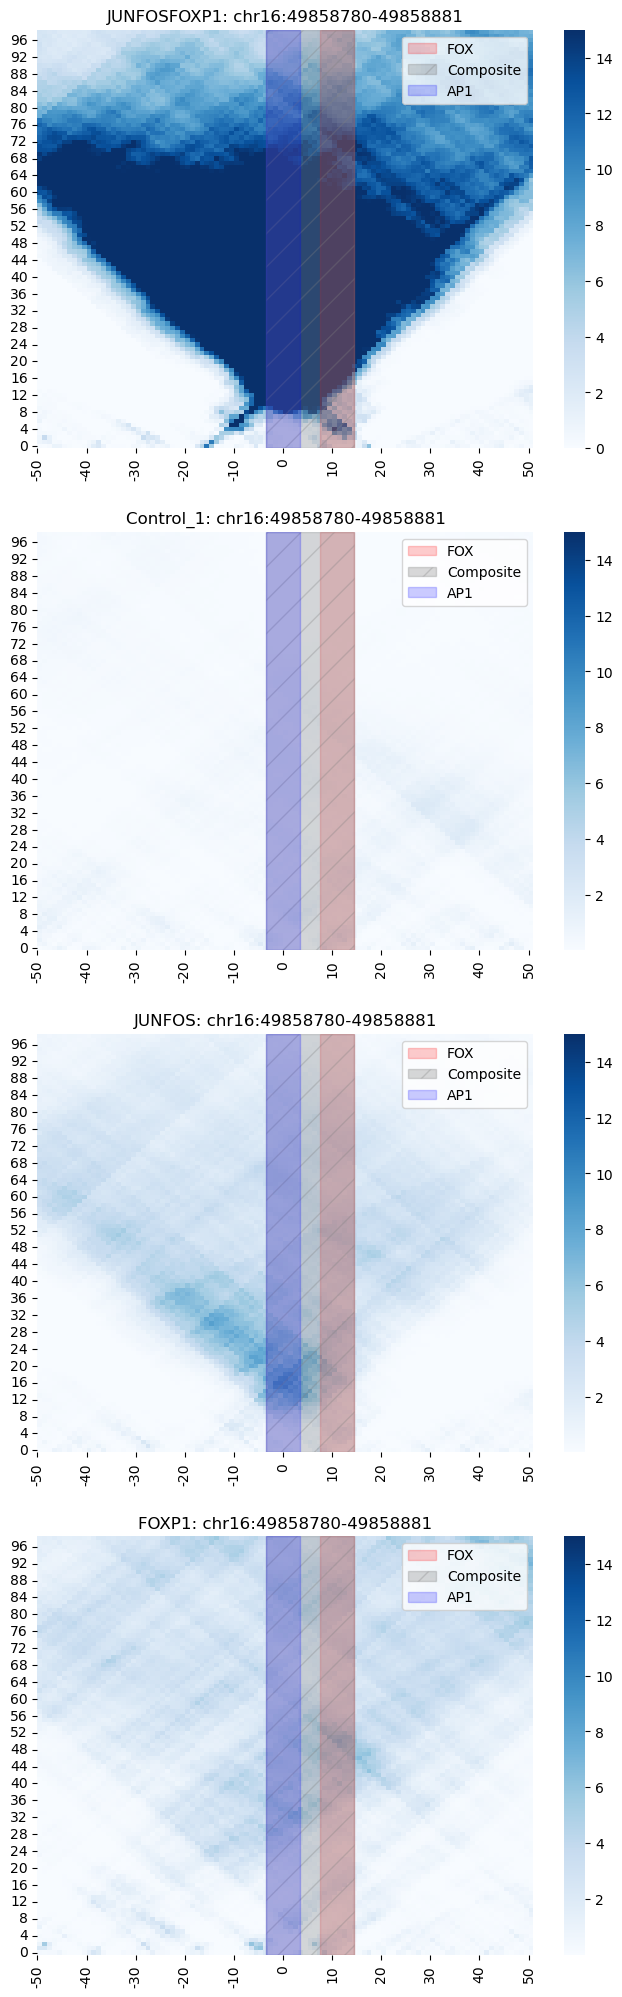

In [24]:
fig, axes= plt.subplots(4,1, figsize=(8,25))
reg=5
i=0

multiscales=multis_ap1fox[reg][foxp1_keep]

for mult, ax, title in zip(multiscales, axes.ravel(), np.array(labels)[foxp1_keep]):

    row = regs_ap1fox.iloc[reg]
    #get composite start and end relative to AP1 motif center
    composite_loc=row['composite_match_loc']
    #fix Regions dataframe saving error with tuples 
    composite_loc=ast.literal_eval(composite_loc)

    
    chrom=row['Chromosome']
    s=row['motif_start']
    e=row['motif_end']
    m=(s+e)//2
    reg_id=chrom+':'+str(m-50)+'-'+str(m+51)
    
    if row['composite_orientation']=='forward':

        #specify within the composite, where the fox and ap1 components fall
        #composite motif = 'TATTTAC....TGA.TCA'
        fox_loc_s=composite_loc[0]
        fox_loc_e=composite_loc[0]+6
        
        jun_loc_s=composite_loc[1]-7
        jun_loc_e=composite_loc[1]-1

        
    if row['composite_orientation']=='reverse':

        #specify within the composite, where the fox and ap1 components fall
        #composite motif = 'TATTTAC....TGA.TCA'
        fox_loc_s=composite_loc[1]-7
        fox_loc_e=composite_loc[1]-1
        
        jun_loc_s=composite_loc[0]
        jun_loc_e=composite_loc[0]+6
    
    
    sns.heatmap(mult[:,50:151], cmap='Blues',vmax=15, ax=ax)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0,110,10),np.arange(-50,60,10))
    
    ax.axvspan(fox_loc_s-0.5+50, fox_loc_e+0.5+50, color='red', alpha=0.2, label='FOX')
    ax.axvspan(composite_loc[0]-0.5+50, composite_loc[1]-1+0.5+50, color='gray', hatch='/',alpha=0.3, label='Composite')
    ax.axvspan(jun_loc_s-0.5+50, jun_loc_e+0.5+50, color='blue', alpha=0.2, label='AP1')
    ax.legend()
    ax.set_title(title+': '+reg_id)
    
    i+=1


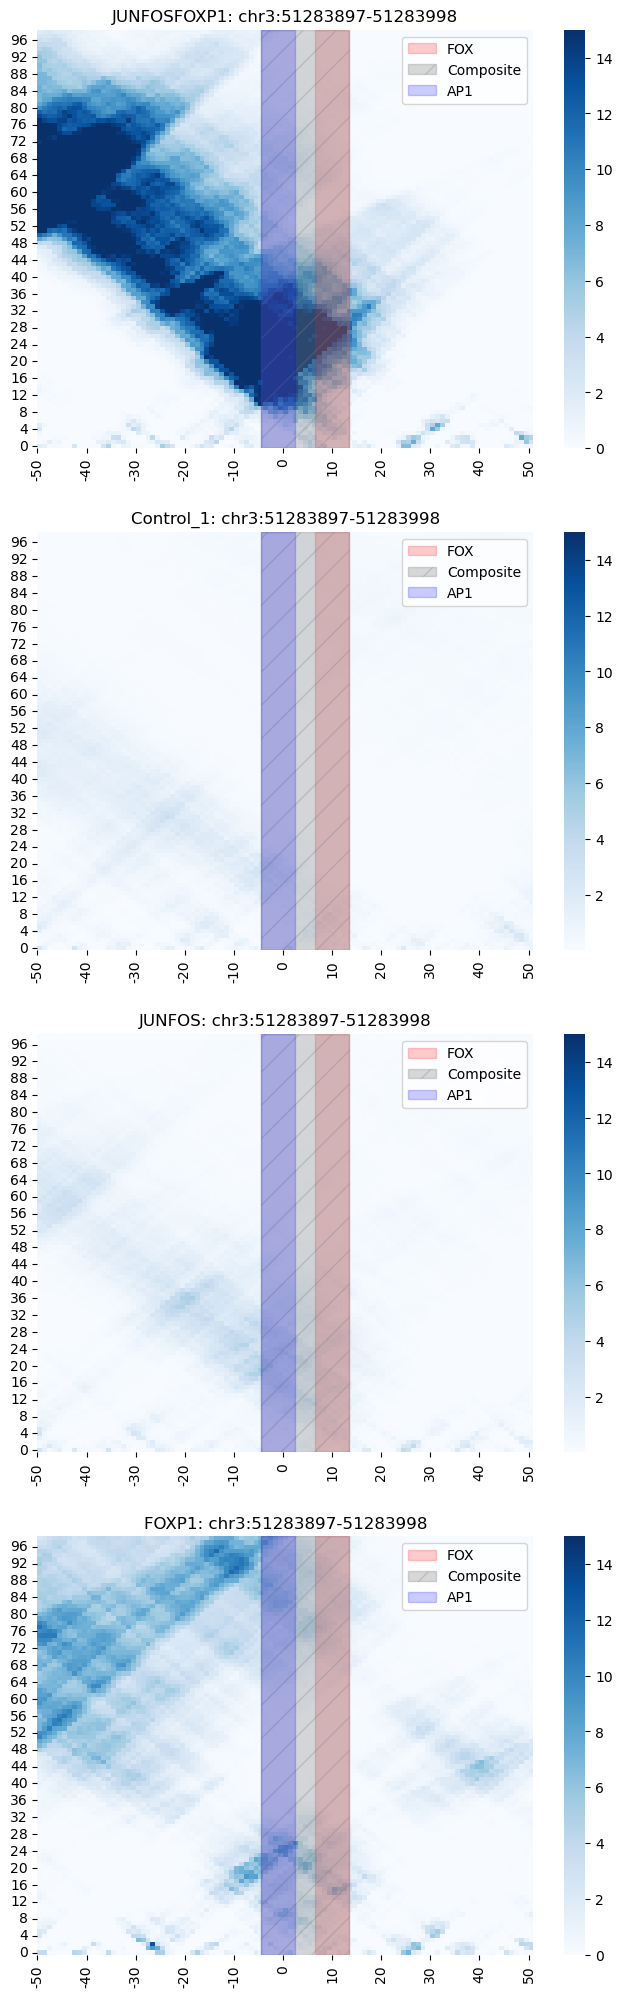

In [25]:
fig, axes= plt.subplots(4,1, figsize=(8,25))
reg=30
i=0

multiscales=multis_ap1fox[reg][foxp1_keep]

for mult, ax, title in zip(multiscales, axes.ravel(), np.array(labels)[foxp1_keep]):

    row = regs_ap1fox.iloc[reg]
    #get composite start and end relative to AP1 motif center
    composite_loc=row['composite_match_loc']
    #fix Regions dataframe saving error with tuples 
    composite_loc=ast.literal_eval(composite_loc)

    
    chrom=row['Chromosome']
    s=row['motif_start']
    e=row['motif_end']
    m=(s+e)//2
    reg_id=chrom+':'+str(m-50)+'-'+str(m+51)
    
    if row['composite_orientation']=='forward':

        #specify within the composite, where the fox and ap1 components fall
        #composite motif = 'TATTTAC....TGA.TCA'
        fox_loc_s=composite_loc[0]
        fox_loc_e=composite_loc[0]+6
        
        jun_loc_s=composite_loc[1]-7
        jun_loc_e=composite_loc[1]-1

        
    if row['composite_orientation']=='reverse':

        #specify within the composite, where the fox and ap1 components fall
        #composite motif = 'TATTTAC....TGA.TCA'
        fox_loc_s=composite_loc[1]-7
        fox_loc_e=composite_loc[1]-1
        
        jun_loc_s=composite_loc[0]
        jun_loc_e=composite_loc[0]+6
    
    
    sns.heatmap(mult[:,50:151], cmap='Blues',vmax=15, ax=ax)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(0,110,10),np.arange(-50,60,10))
    
    ax.axvspan(fox_loc_s-0.5+50, fox_loc_e+0.5+50, color='red', alpha=0.2, label='FOX')
    ax.axvspan(composite_loc[0]-0.5+50, composite_loc[1]-1+0.5+50, color='gray', hatch='/',alpha=0.3, label='Composite')
    ax.axvspan(jun_loc_s-0.5+50, jun_loc_e+0.5+50, color='blue', alpha=0.2, label='AP1')
    ax.legend()
    ax.set_title(title+': '+reg_id)
    
    i+=1
